# Decoding Strategy & Evaluation Metric(BLEU & ROUGE)

In [ ]:
# Install required libraries for using transformer
!pip install transformers

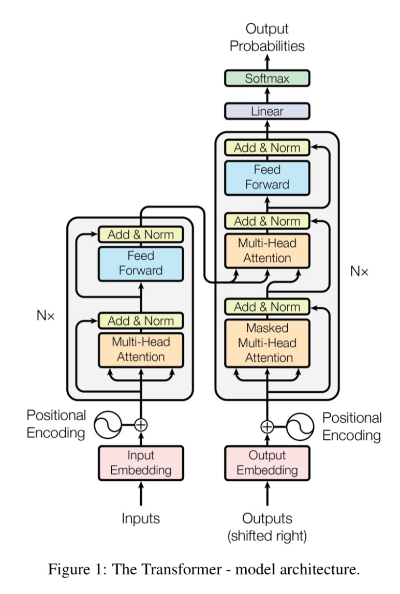

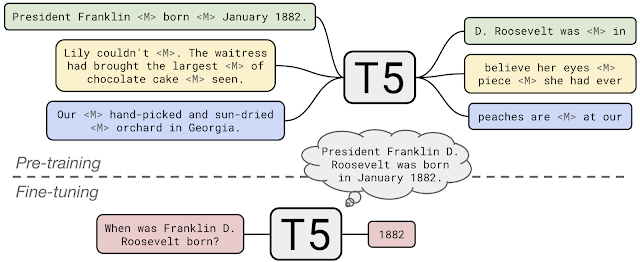

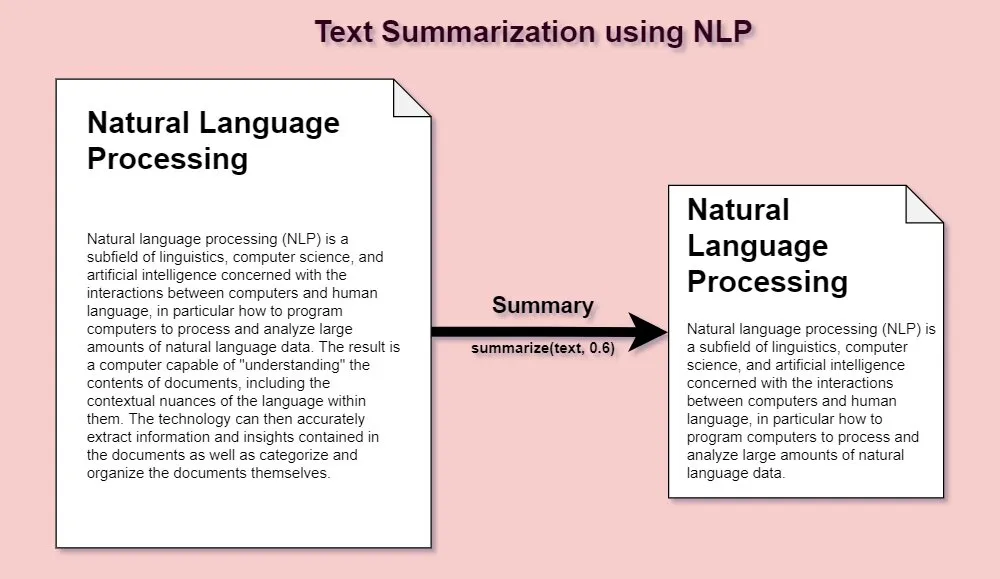

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load tokenizer and model
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
# Example of long English text for summarization

article = """
When generating text, large language models need to carefully balance fluency and creativity to produce meaningful and engaging responses.
Greedy decoding often leads to safe but highly repetitive sentences, because it always selects the most probable next token without considering alternative possibilities.
Beam search improves output quality by exploring multiple candidate sequences at each time step, but it still tends to prioritize high-probability tokens, which can limit diversity.
In contrast, sampling-based methods such as top-k or nucleus (top-p) sampling allow the model to consider lower-probability tokens, introducing greater variation and creativity in the generated text.
However, this increased flexibility comes with a risk: if the model selects tokens with very low probability, the output may become less coherent or contain factual errors.
Therefore, choosing an appropriate decoding strategy is crucial for balancing reliability and diversity in text generation.
"""

# Prepare input for T5 text summarization task
text = "summarize: " + article

# Other task examples:
#   "translate English to German: <text>"
#   "classify sentiment: <text>"
#   "answer question: <question> context: <context>"

# Tokenize and move input to the selected device
inputs = tokenizer(text, return_tensors="pt").to(device)

In [ ]:
# Decode generated token IDs into text (skip special tokens like <pad>, </s>)
def decode_output(output):
    return tokenizer.decode(output[0], skip_special_tokens=True)

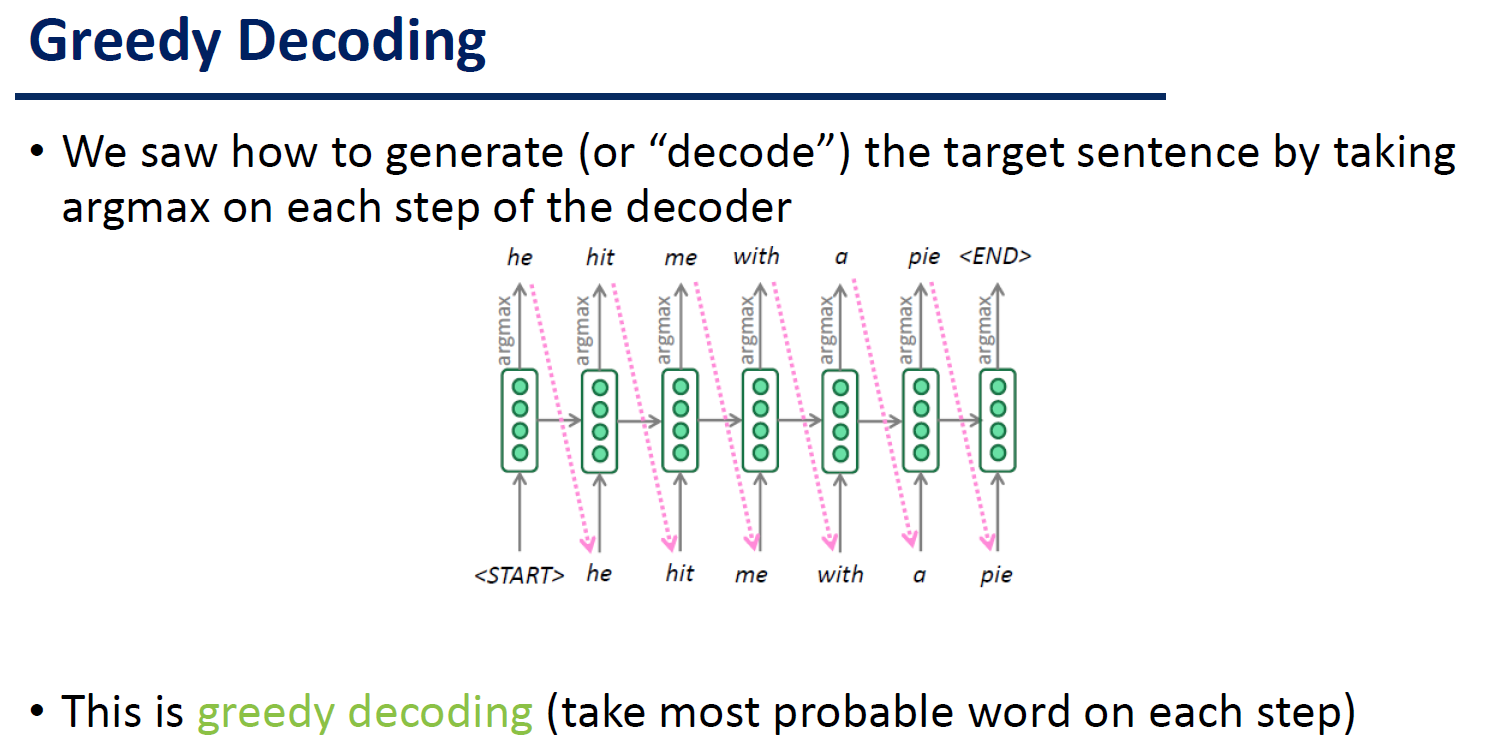

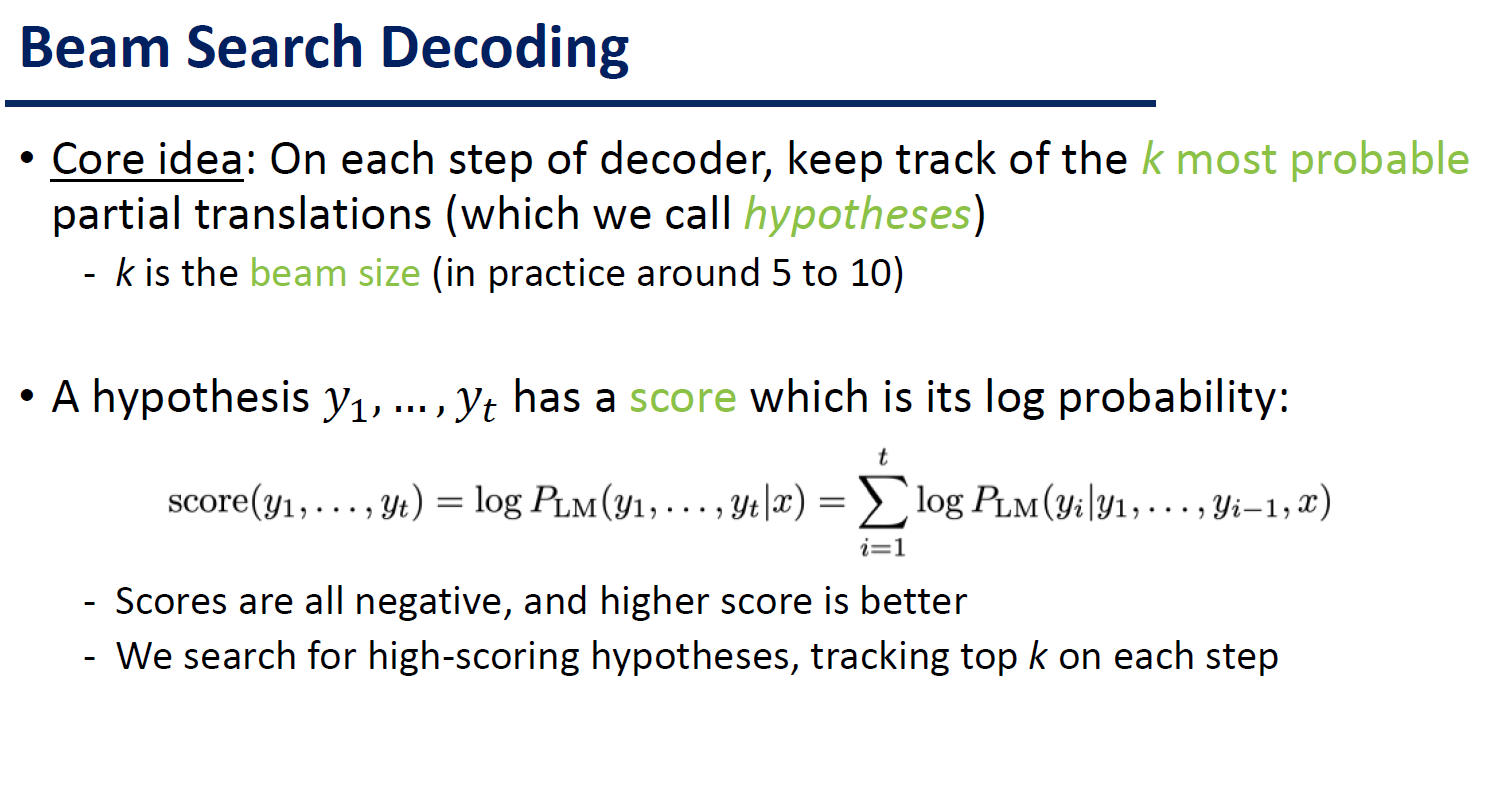

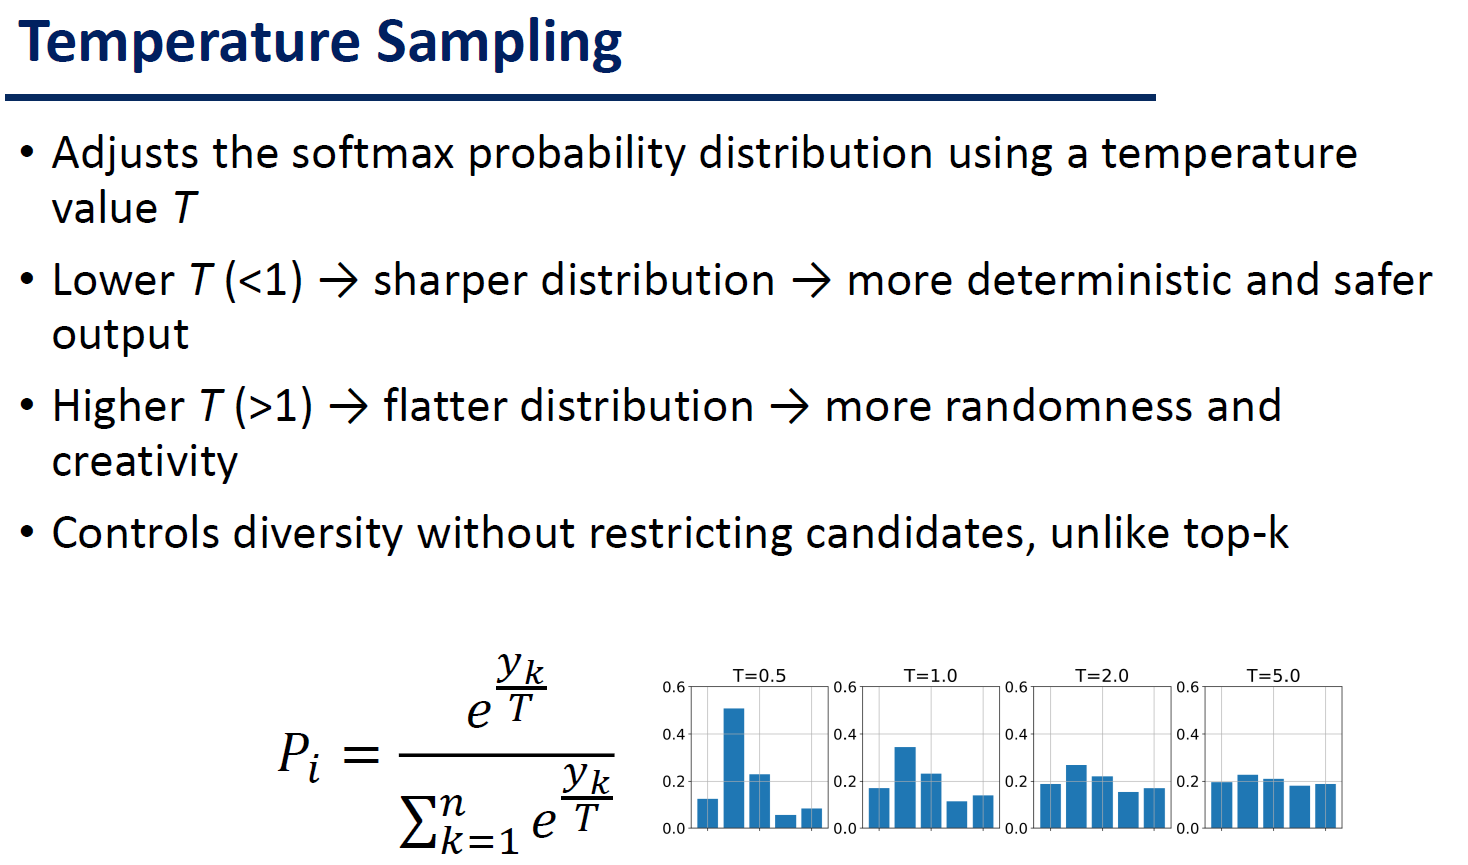

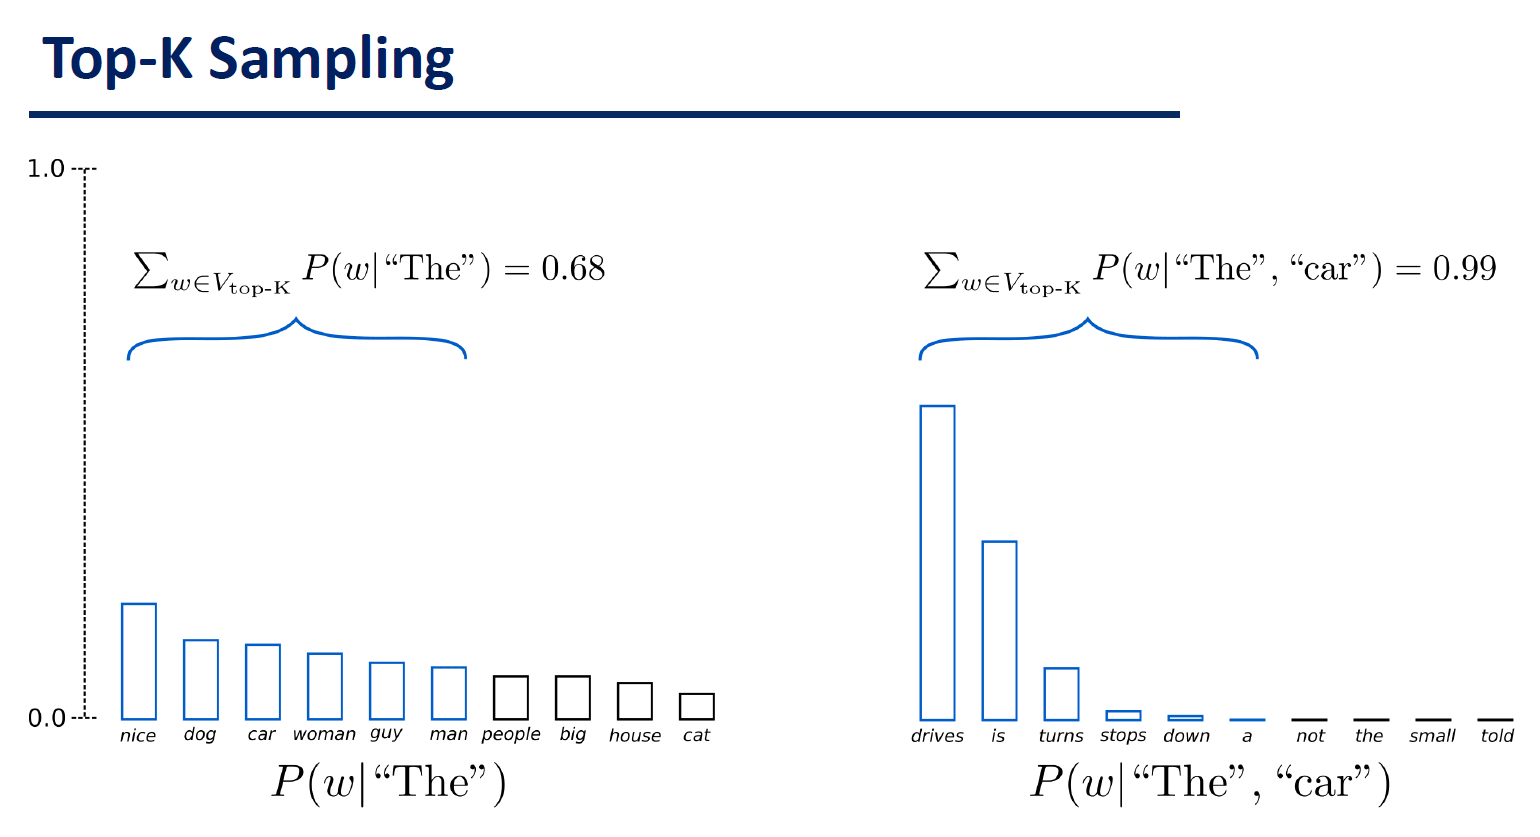

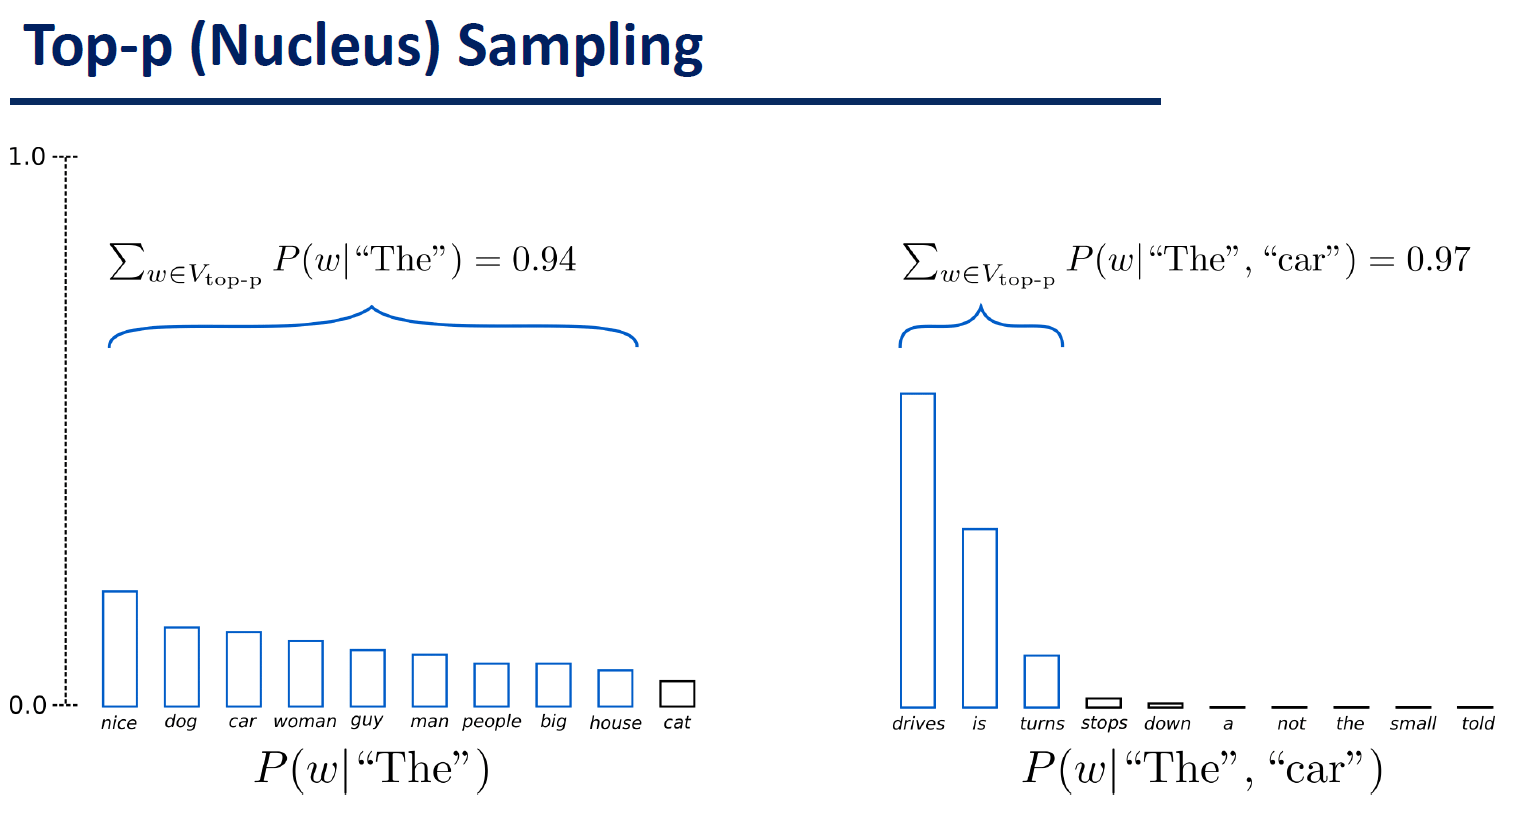

In [ ]:
# 1) Greedy Decoding
out_greedy = model.generate(
    **inputs,
    max_length=40
)

# 2) Beam Search (Only num_beams added)
out_beam = model.generate(
    **inputs,
    num_beams=5,
    max_length=40
)

# 3) Top-k Sampling (Only do_sample + top_k)
out_topk = model.generate(
    **inputs,
    do_sample=True,
    top_k=10,
    max_length=40
)

# 4) Top-p (Nucleus) Sampling (Only do_sample + top_p)
out_topp = model.generate(
    **inputs,
    do_sample=True,
    top_p=0.8,
    max_length=40
)

# 5) Temperature Sampling (Only do_sample + temperature)
out_temp = model.generate(
    **inputs,
    do_sample=True,
    temperature=0.7,
    max_length=40
)

print("▶ Article:\n", article)
print("\n[Greedy]\n", decode_output(out_greedy))
print("\n[Beam k=5]\n", decode_output(out_beam))
print("\n[Top-k]\n", decode_output(out_topk))
print("\n[Top-p]\n", decode_output(out_topp))
print("\n[Temp=0.7]\n", decode_output(out_temp))

In [ ]:
# Generate summary using the model
outputs = model.generate(
    **inputs,
    max_length=40,
    return_dict_in_generate=True,  # Enable detailed generation outputs
    output_scores=True             # Return token-level scores for each step
)

print("Generated summary:", tokenizer.decode(outputs.sequences[0], skip_special_tokens=True))

# Inspect top 5 token probabilities at each generation step
for step, scores in enumerate(outputs.scores):
    if step >= 10:  # Stop after 10 steps
        break
    probs = torch.softmax(scores, dim=-1)  # Convert logits to probabilities
    top5 = torch.topk(probs, 5)            # Get top 5 probable tokens
    tokens = tokenizer.convert_ids_to_tokens(top5.indices[0])
    print(f"Step {step+1}:")
    for t, p in zip(tokens, top5.values[0]):
        print(f"  {t} : {float(p):.4f}")

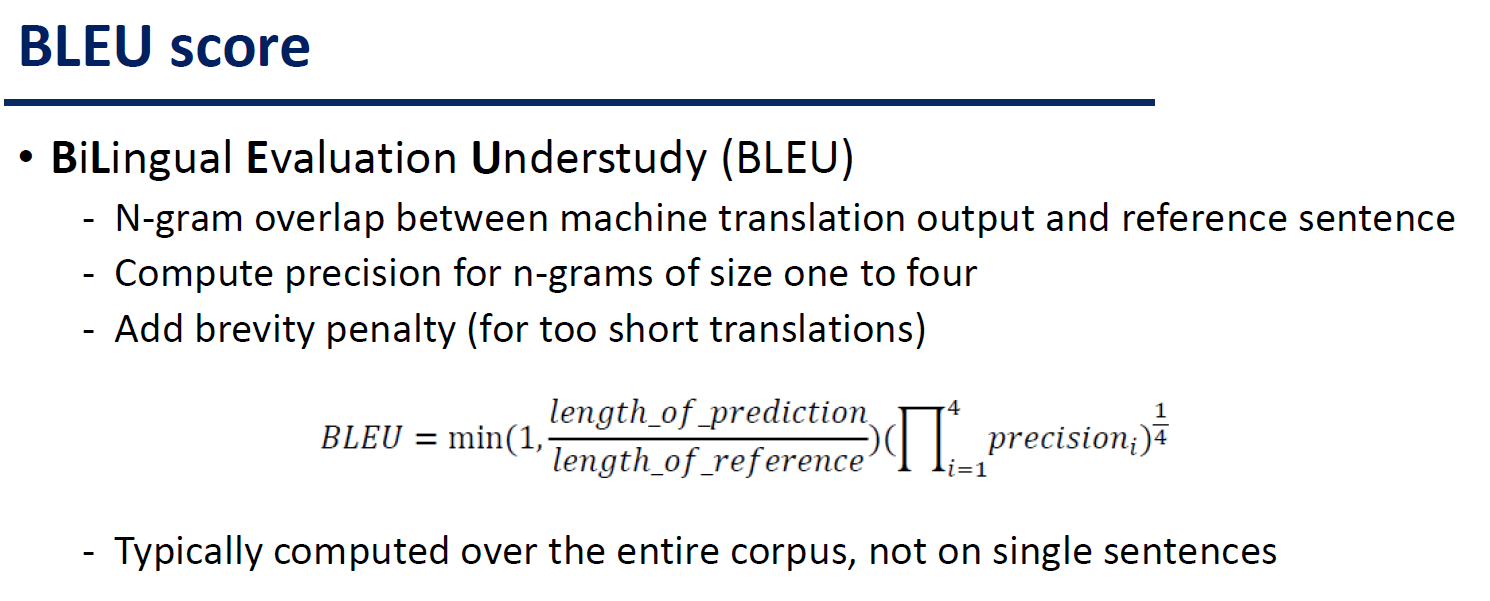

In [ ]:
!pip install torchmetrics -q

In [ ]:
# Import BLEU evaluation metric (based on n-gram precision)
from torchmetrics.text import BLEUScore

In [ ]:
# Use BLEU-4 metric (up to 4-gram matching)
bleu_metric = BLEUScore(n_gram=4)

# 1) Set reference summary (gold standard)
# Example: article title or human-written summary
reference_text = "LLMs need to balance fluency and creativity. Greedy decoding is safe, while sampling increases diversity but can introduce errors."
reference_text = reference_text.lower()

# Format for torchmetrics: list[list[str]]
references = [[reference_text]]

# 2) Generate candidate summaries for each decoding strategy
cand_greedy = decode_output(out_greedy)
cand_beam   = decode_output(out_beam)
cand_topk   = decode_output(out_topk)
cand_topp   = decode_output(out_topp)
cand_temp   = decode_output(out_temp)

# 3) Compare multiple decoding methods in a loop
candidates = {
    "Greedy":     cand_greedy,
    "Beam (k=5)": cand_beam,
    "Top-k":      cand_topk,
    "Top-p":      cand_topp,
    "Temp(0.7)":  cand_temp,
}

for name, cand in candidates.items():
    # BLEU format: preds = [str], target = [[str]]
    score = bleu_metric([cand], references).item()
    print(f"{name:10s} BLEU: {score:.4f}")
    print("  candidate:", cand)
    print()

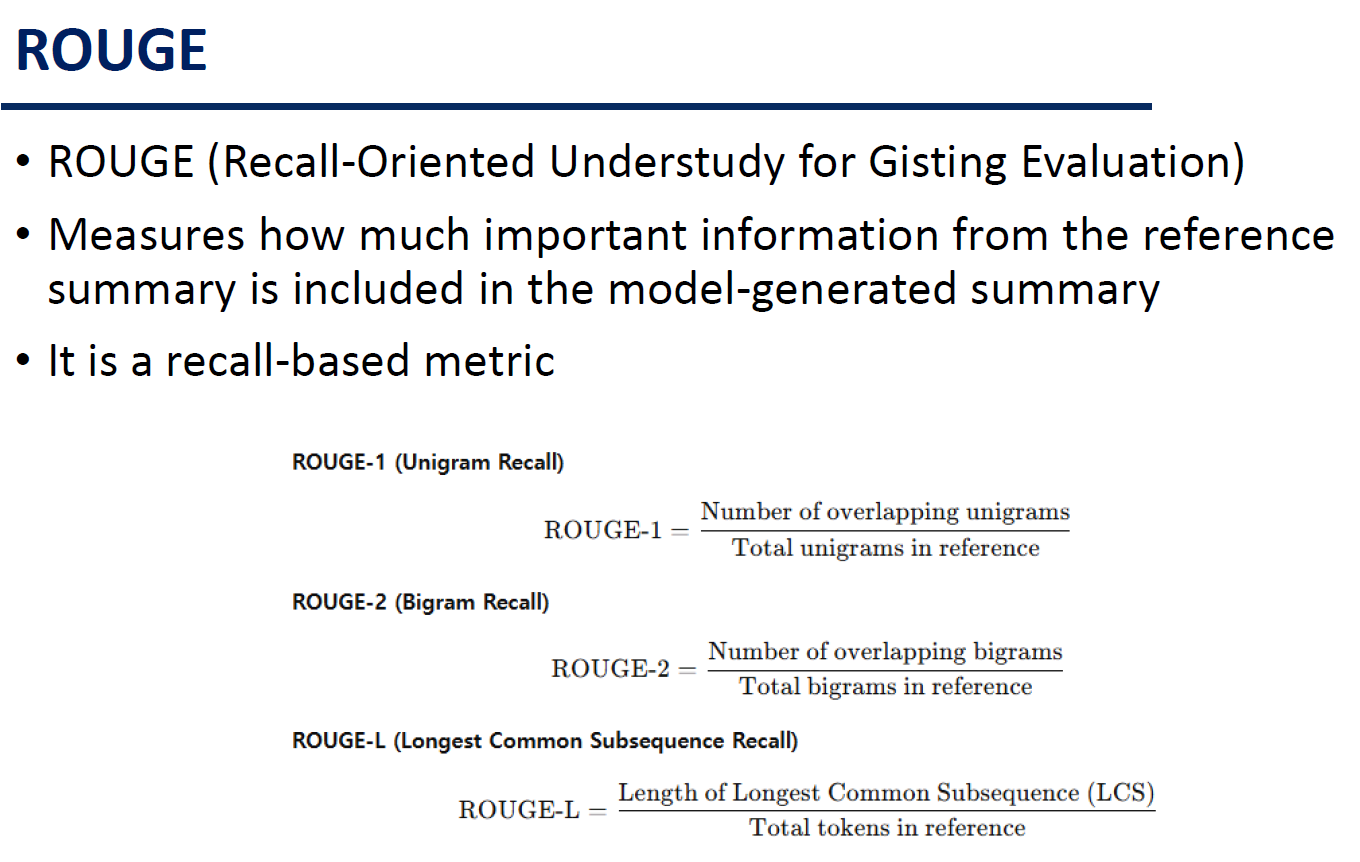

In [ ]:
# Install ROUGE evaluation metric library quietly
!pip install rouge-score -q

In [ ]:
from rouge_score import rouge_scorer

# Example: article title or human-written summary
reference_text = "LLMs need to balance fluency and creativity. Greedy decoding is safe, while sampling increases diversity but can introduce errors."
reference_text = reference_text.lower()

# Convert candidates to lowercase to minimize case sensitivity issues
cand_greedy = decode_output(out_greedy).lower()
cand_beam   = decode_output(out_beam).lower()
cand_topk   = decode_output(out_topk).lower()
cand_topp   = decode_output(out_topp).lower()
cand_temp   = decode_output(out_temp).lower()

candidates = {
    "Greedy"    : cand_greedy,
    "Beam (k=5)": cand_beam,
    "Top-k"     : cand_topk,
    "Top-p"     : cand_topp,
    "Temp(0.7)" : cand_temp,
}

# Use ROUGE-1, ROUGE-2, and ROUGE-L metrics (stemmer recommended)
scorer = rouge_scorer.RougeScorer(
    ['rouge1', 'rouge2', 'rougeL'],
    use_stemmer=True
)

for name, cand in candidates.items():
    scores = scorer.score(reference_text, cand)
    r1 = scores['rouge1'].recall     # Recall-based ROUGE-1
    r2 = scores['rouge2'].recall     # Recall-based ROUGE-2
    rL = scores['rougeL'].recall     # Recall-based ROUGE-L

    print(f"[{name}]")
    print(f"  ROUGE-1 Recall: {r1:.4f}")
    print(f"  ROUGE-2 Recall: {r2:.4f}")
    print(f"  ROUGE-L Recall: {rL:.4f}")
    print(f"  candidate: {cand}")
    print()